# Libraries


In [40]:
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import torch
import torch.nn as nn 
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as TF
import copy
import cv2

# U-net parts

In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)


class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
       x1 = self.up(x1)
       x = torch.cat([x1, x2], 1)
       return self.conv(x)

# U-net arch

In [3]:

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
       down_1, p1 = self.down_convolution_1(x)
       down_2, p2 = self.down_convolution_2(p1)
       down_3, p3 = self.down_convolution_3(p2)
       down_4, p4 = self.down_convolution_4(p3)

       b = self.bottle_neck(p4)

       up_1 = self.up_convolution_1(b, down_4)
       up_2 = self.up_convolution_2(up_1, down_3)
       up_3 = self.up_convolution_3(up_2, down_2)
       up_4 = self.up_convolution_4(up_3, down_1)

       out = self.out(up_4)
       return out

# model = UNet(3,1)
# print(model.state_dict())

# Dataset 

In [4]:

class BarcodeDataset(Dataset):
    def __init__(self, root_path, test=False):
        self.root_path = root_path
        if test:
            self.images = sorted([root_path + "/test/image/" + i for i in os.listdir(root_path + "/test/image/")])
            self.masks = sorted(
                [root_path + "/test/mask/" + i for i in os.listdir(root_path + "/test/mask/")])
        else:
            self.images = sorted([root_path + "/train/image/" + i for i in os.listdir(root_path + "/train/image/")])
            self.masks = sorted([root_path + "/train/mask/" + i for i in os.listdir(root_path + "/train/mask/")])

        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor()])

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB")
        mask = Image.open(self.masks[index]).convert("L")

        return self.transform(img), self.transform(mask)

    def __len__(self):
        return len(self.images)


# Metrics (Accuracy and IoU):
`Accuracy = (TP + TN)/(TP + TN + FP + FN)`

In [5]:
def calculate_iou(predicted_probs, binary_mask):
    predicted_mask = (predicted_probs >= 0.5).float()
    intersection = torch.logical_and(predicted_mask, binary_mask).sum()
    union = torch.logical_or(predicted_mask, binary_mask).sum()
    iou = intersection.float() / union.float()
    # iou *= 100
    return iou.item()

def calculate_accuracy(predicted_probs, binary_mask):
    predicted_mask = (predicted_probs >= 0.5).float()

    true_positives = torch.logical_and(predicted_mask, binary_mask).sum()
    true_negatives = torch.logical_not(torch.logical_or(predicted_mask, binary_mask)).sum()
    false_positives = torch.logical_and(torch.logical_not(predicted_mask), binary_mask).sum()
    false_negatives = torch.logical_and(predicted_mask, torch.logical_not(binary_mask)).sum()
    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
    precision = (true_positives) / (true_positives + false_positives)

    # accuracy = (predicted_mask == binary_mask).float().mean().item()
    return  accuracy.item()        #   accuracy.item()

# Training and saving the model

In [6]:
training_loss = []
validation_loss = []
training_iou = []
validation_iou = []
training_acc = []
validation_acc = []
ep = []
LEARNING_RATE = 1e-5
BATCH_SIZE = 4
EPOCHS = 100
DATA_PATH = "/home/aous/Desktop/MIPT/project/data 3"
MODEL_SAVE_PATH = "/home/aous/Desktop/MIPT/project/models/"

device = "cuda" if torch.cuda.is_available() else "cpu"
train_dataset = BarcodeDataset(DATA_PATH)

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2], generator=generator)

train_dataloader = DataLoader(dataset=train_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True)

model_data3_03 = UNet(in_channels=3, num_classes=1).to(device)
optimizer = optim.AdamW(model_data3_03.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

# for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch + 1}")
    model_data3_03.train()
    train_running_loss = 0
    train_running_iou = 0
    train_running_acc = 0

    for idx, img_mask in enumerate(tqdm(train_dataloader)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)

        y_pred = model_data3_03(img)
        optimizer.zero_grad()
        iou = calculate_iou(y_pred, mask)
        acc = calculate_accuracy(y_pred, mask)
            # iou = round(iou, 2)
        train_running_iou += iou
        train_running_acc += acc
        loss = criterion(y_pred, mask)
        train_running_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / (idx + 1)
    train_iou = train_running_iou / (idx + 1)
    train_acc = train_running_acc / (idx + 1)

    model_data3_03.eval()
    val_running_loss = 0
    val_running_iou = 0
    val_running_acc = 0
    with torch.no_grad():
        for idx, img_mask in enumerate(tqdm(val_dataloader)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)

            y_pred = model_data3_03(img)
            iou = calculate_iou(y_pred, mask)
            acc = calculate_accuracy(y_pred, mask)
            val_running_iou += iou
            val_running_acc += acc
            loss = criterion(y_pred, mask)
            val_running_loss += loss.item()

            val_loss = val_running_loss / (idx + 1)
            val_iou = val_running_iou / (idx + 1)
            val_acc = val_running_acc / (idx + 1)

    train_loss = round(train_loss, 4)
    val_loss = round(val_loss, 4)
    train_iou = round(train_iou, 10)
    val_iou = round(val_iou, 10)
    train_acc = round(train_acc, 10)
    val_acc = round(val_acc, 10)


    training_loss.append(train_loss)
    validation_loss.append(val_loss)
    training_iou.append(train_iou)
    validation_iou.append(val_iou)
    training_acc.append(train_acc)
    validation_acc.append(val_acc)
    ep.append(epoch + 1)
    print("-" * 30)
    print(f"Train Loss EPOCH {epoch + 1}: {train_loss}")
    print(f"Valid Loss EPOCH {epoch + 1}: {val_loss}")
    print(f"Train IoU EPOCH {epoch + 1}: {train_iou}")
    print(f"Valid IoU EPOCH {epoch + 1}: {val_iou}")
    print(f"Train Acc EPOCH {epoch + 1}: {train_acc}")
    print(f"Valid Acc EPOCH {epoch + 1}: {val_acc}")  # {val_acc:.4f}
    print("-" * 30)

MODEL_SAVE_PATH = MODEL_SAVE_PATH + "model_data3_03.pth"
torch.save(model_data3_03.state_dict(), MODEL_SAVE_PATH)


  0%|                                                   | 0/100 [00:00<?, ?it/s]

Epoch: 1



100%|█████████████████████████████████████████| 308/308 [03:36<00:00,  1.43it/s]

  1%|▍                                       | 1/100 [03:56<6:30:46, 236.84s/it]

------------------------------
Train Loss EPOCH 1: 0.3984
Valid Loss EPOCH 1: 0.2585
Train IoU EPOCH 1: 0.0
Valid IoU EPOCH 1: 0.0
Train Acc EPOCH 1: 0.9384986456
Valid Acc EPOCH 1: 0.9362842967
------------------------------
Epoch: 2



100%|█████████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

  2%|▊                                       | 2/100 [07:54<6:27:33, 237.28s/it]

------------------------------
Train Loss EPOCH 2: 0.2233
Valid Loss EPOCH 2: 0.2018
Train IoU EPOCH 2: 0.0
Valid IoU EPOCH 2: 0.0
Train Acc EPOCH 2: 0.9384986456
Valid Acc EPOCH 2: 0.9363158957
------------------------------
Epoch: 3



100%|█████████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

  3%|█▏                                      | 3/100 [11:51<6:23:35, 237.27s/it]

------------------------------
Train Loss EPOCH 3: 0.1892
Valid Loss EPOCH 3: 0.18
Train IoU EPOCH 3: 0.0
Valid IoU EPOCH 3: 0.0
Train Acc EPOCH 3: 0.9384986456
Valid Acc EPOCH 3: 0.9362284634
------------------------------
Epoch: 4



100%|█████████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

  4%|█▌                                      | 4/100 [15:49<6:19:56, 237.46s/it]

------------------------------
Train Loss EPOCH 4: 0.1591
Valid Loss EPOCH 4: 0.1478
Train IoU EPOCH 4: 0.0
Valid IoU EPOCH 4: 0.0
Train Acc EPOCH 4: 0.9384986456
Valid Acc EPOCH 4: 0.9362823065
------------------------------
Epoch: 5



100%|█████████████████████████████████████████| 308/308 [03:37<00:00,  1.41it/s]

  5%|██                                      | 5/100 [19:47<6:16:12, 237.60s/it]

------------------------------
Train Loss EPOCH 5: 0.1373
Valid Loss EPOCH 5: 0.1307
Train IoU EPOCH 5: 0.0
Valid IoU EPOCH 5: 0.0
Train Acc EPOCH 5: 0.9384986456
Valid Acc EPOCH 5: 0.9362732567
------------------------------
Epoch: 6



100%|█████████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

  6%|██▍                                     | 6/100 [23:44<6:12:11, 237.57s/it]

------------------------------
Train Loss EPOCH 6: 0.122
Valid Loss EPOCH 6: 0.1249
Train IoU EPOCH 6: 0.1098915578
Valid IoU EPOCH 6: 0.3533735985
Train Acc EPOCH 6: 0.9425002662
Valid Acc EPOCH 6: 0.9502643362
------------------------------
Epoch: 7



100%|█████████████████████████████████████████| 308/308 [03:37<00:00,  1.41it/s]

  7%|██▊                                     | 7/100 [27:42<6:08:20, 237.64s/it]

------------------------------
Train Loss EPOCH 7: 0.1156
Valid Loss EPOCH 7: 0.1123
Train IoU EPOCH 7: 0.2907940765
Valid IoU EPOCH 7: 0.3507140767
Train Acc EPOCH 7: 0.9517069761
Valid Acc EPOCH 7: 0.9568583586
------------------------------
Epoch: 8



100%|█████████████████████████████████████████| 308/308 [03:37<00:00,  1.41it/s]

  8%|███▏                                    | 8/100 [31:40<6:04:33, 237.76s/it]

------------------------------
Train Loss EPOCH 8: 0.1048
Valid Loss EPOCH 8: 0.1276
Train IoU EPOCH 8: 0.4078541163
Valid IoU EPOCH 8: 0.1690427699
Train Acc EPOCH 8: 0.9599794227
Valid Acc EPOCH 8: 0.9476524243
------------------------------
Epoch: 9



100%|█████████████████████████████████████████| 308/308 [03:38<00:00,  1.41it/s]

  9%|███▌                                    | 9/100 [35:38<6:00:43, 237.84s/it]

------------------------------
Train Loss EPOCH 9: 0.0993
Valid Loss EPOCH 9: 0.1125
Train IoU EPOCH 9: 0.4235383952
Valid IoU EPOCH 9: 0.2167071564
Train Acc EPOCH 9: 0.9628718457
Valid Acc EPOCH 9: 0.9517149825
------------------------------
Epoch: 10



100%|█████████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 10%|███▉                                   | 10/100 [39:36<5:56:33, 237.71s/it]

------------------------------
Train Loss EPOCH 10: 0.0963
Valid Loss EPOCH 10: 0.0948
Train IoU EPOCH 10: 0.4340302225
Valid IoU EPOCH 10: 0.4612581208
Train Acc EPOCH 10: 0.964017193
Valid Acc EPOCH 10: 0.9647385571
------------------------------
Epoch: 11



100%|█████████████████████████████████████████| 308/308 [03:38<00:00,  1.41it/s]

 11%|████▎                                  | 11/100 [43:34<5:52:47, 237.84s/it]

------------------------------
Train Loss EPOCH 11: 0.0907
Valid Loss EPOCH 11: 0.0927
Train IoU EPOCH 11: 0.4545528963
Valid IoU EPOCH 11: 0.4222111441
Train Acc EPOCH 11: 0.9660936517
Valid Acc EPOCH 11: 0.9640272894
------------------------------
Epoch: 12



100%|█████████████████████████████████████████| 308/308 [03:37<00:00,  1.41it/s]

 12%|████▋                                  | 12/100 [47:32<5:48:56, 237.92s/it]

------------------------------
Train Loss EPOCH 12: 0.0898
Valid Loss EPOCH 12: 0.1085
Train IoU EPOCH 12: 0.4458064589
Valid IoU EPOCH 12: 0.2735024414
Train Acc EPOCH 12: 0.9665097509
Valid Acc EPOCH 12: 0.9555149945
------------------------------
Epoch: 13



100%|█████████████████████████████████████████| 308/308 [03:37<00:00,  1.41it/s]

 13%|█████                                  | 13/100 [51:30<5:45:02, 237.95s/it]

------------------------------
Train Loss EPOCH 13: 0.0834
Valid Loss EPOCH 13: 0.0906
Train IoU EPOCH 13: 0.4783388909
Valid IoU EPOCH 13: 0.5074886996
Train Acc EPOCH 13: 0.9690377217
Valid Acc EPOCH 13: 0.9672018979
------------------------------
Epoch: 14



100%|█████████████████████████████████████████| 308/308 [03:38<00:00,  1.41it/s]

 14%|█████▍                                 | 14/100 [55:28<5:41:09, 238.02s/it]

------------------------------
Train Loss EPOCH 14: 0.0841
Valid Loss EPOCH 14: 0.0837
Train IoU EPOCH 14: 0.4708682412
Valid IoU EPOCH 14: 0.4767855888
Train Acc EPOCH 14: 0.9683314639
Valid Acc EPOCH 14: 0.9675489114
------------------------------
Epoch: 15



100%|█████████████████████████████████████████| 308/308 [03:37<00:00,  1.41it/s]

 15%|█████▊                                 | 15/100 [59:26<5:37:13, 238.04s/it]

------------------------------
Train Loss EPOCH 15: 0.0807
Valid Loss EPOCH 15: 0.0924
Train IoU EPOCH 15: 0.4733278876
Valid IoU EPOCH 15: 0.5050549569
Train Acc EPOCH 15: 0.9696179768
Valid Acc EPOCH 15: 0.9681327746
------------------------------
Epoch: 16



100%|█████████████████████████████████████████| 308/308 [03:38<00:00,  1.41it/s]

 16%|█████▉                               | 16/100 [1:03:24<5:33:18, 238.08s/it]

------------------------------
Train Loss EPOCH 16: 0.0795
Valid Loss EPOCH 16: 0.0844
Train IoU EPOCH 16: 0.4897666414
Valid IoU EPOCH 16: 0.4417333444
Train Acc EPOCH 16: 0.9696065791
Valid Acc EPOCH 16: 0.9658856825
------------------------------
Epoch: 17



100%|█████████████████████████████████████████| 308/308 [03:38<00:00,  1.41it/s]

 17%|██████▎                              | 17/100 [1:07:22<5:29:24, 238.12s/it]

------------------------------
Train Loss EPOCH 17: 0.0755
Valid Loss EPOCH 17: 0.0882
Train IoU EPOCH 17: 0.5045226578
Valid IoU EPOCH 17: 0.5647342394
Train Acc EPOCH 17: 0.9714795119
Valid Acc EPOCH 17: 0.9693012199
------------------------------
Epoch: 18



100%|█████████████████████████████████████████| 308/308 [03:38<00:00,  1.41it/s]

 18%|██████▋                              | 18/100 [1:11:21<5:25:27, 238.14s/it]

------------------------------
Train Loss EPOCH 18: 0.0766
Valid Loss EPOCH 18: 0.0826
Train IoU EPOCH 18: 0.5121481643
Valid IoU EPOCH 18: 0.4902765001
Train Acc EPOCH 18: 0.9712176787
Valid Acc EPOCH 18: 0.9682750121
------------------------------
Epoch: 19



100%|█████████████████████████████████████████| 308/308 [03:38<00:00,  1.41it/s]

 19%|███████                              | 19/100 [1:15:19<5:21:36, 238.23s/it]

------------------------------
Train Loss EPOCH 19: 0.0722
Valid Loss EPOCH 19: 0.0865
Train IoU EPOCH 19: 0.5394349909
Valid IoU EPOCH 19: 0.556178392
Train Acc EPOCH 19: 0.9729980029
Valid Acc EPOCH 19: 0.9709031156
------------------------------
Epoch: 20



100%|█████████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 20%|███████▍                             | 20/100 [1:19:17<5:17:22, 238.03s/it]

------------------------------
Train Loss EPOCH 20: 0.0746
Valid Loss EPOCH 20: 0.076
Train IoU EPOCH 20: 0.5165574962
Valid IoU EPOCH 20: 0.5788686219
Train Acc EPOCH 20: 0.971653381
Valid Acc EPOCH 20: 0.9723895223
------------------------------
Epoch: 21



100%|█████████████████████████████████████████| 308/308 [03:39<00:00,  1.40it/s]

 21%|███████▊                             | 21/100 [1:23:17<5:14:10, 238.62s/it]

------------------------------
Train Loss EPOCH 21: 0.0665
Valid Loss EPOCH 21: 0.0713
Train IoU EPOCH 21: 0.5651619695
Valid IoU EPOCH 21: 0.4736329157
Train Acc EPOCH 21: 0.9749263602
Valid Acc EPOCH 21: 0.9690859163
------------------------------
Epoch: 22



100%|█████████████████████████████████████████| 308/308 [03:38<00:00,  1.41it/s]

 22%|████████▏                            | 22/100 [1:27:15<5:10:01, 238.49s/it]

------------------------------
Train Loss EPOCH 22: 0.0646
Valid Loss EPOCH 22: 0.068
Train IoU EPOCH 22: 0.5712261966
Valid IoU EPOCH 22: 0.496107848
Train Acc EPOCH 22: 0.9759568827
Valid Acc EPOCH 22: 0.9713285952
------------------------------
Epoch: 23



100%|█████████████████████████████████████████| 308/308 [03:39<00:00,  1.41it/s]

 23%|████████▌                            | 23/100 [1:31:14<5:06:22, 238.73s/it]

------------------------------
Train Loss EPOCH 23: 0.0631
Valid Loss EPOCH 23: 0.0644
Train IoU EPOCH 23: 0.59587942
Valid IoU EPOCH 23: 0.5771281293
Train Acc EPOCH 23: 0.9764788398
Valid Acc EPOCH 23: 0.9747169382
------------------------------
Epoch: 24



100%|█████████████████████████████████████████| 308/308 [03:11<00:00,  1.61it/s]

 24%|████████▉                            | 24/100 [1:34:43<4:51:03, 229.78s/it]

------------------------------
Train Loss EPOCH 24: 0.0582
Valid Loss EPOCH 24: 0.0653
Train IoU EPOCH 24: 0.6231863053
Valid IoU EPOCH 24: 0.5071434166
Train Acc EPOCH 24: 0.977912426
Valid Acc EPOCH 24: 0.9718779565
------------------------------
Epoch: 25



100%|███████████████████████████████████| 308/308 [03:10<00:00,  1.62it/s]

 25%|█████████▎                           | 25/100 [1:38:11<4:38:58, 223.19s/it]

------------------------------
Train Loss EPOCH 25: 0.0554
Valid Loss EPOCH 25: 0.0564
Train IoU EPOCH 25: 0.6494392728
Valid IoU EPOCH 25: 0.6362307421
Train Acc EPOCH 25: 0.9793892093
Valid Acc EPOCH 25: 0.9791571544
------------------------------
Epoch: 26



100%|███████████████████████████████████| 308/308 [03:10<00:00,  1.62it/s]

 26%|█████████▌                           | 26/100 [1:41:38<4:29:29, 218.51s/it]

------------------------------
Train Loss EPOCH 26: 0.0513
Valid Loss EPOCH 26: 0.1
Train IoU EPOCH 26: 0.6607937777
Valid IoU EPOCH 26: 0.5566461845
Train Acc EPOCH 26: 0.980667975
Valid Acc EPOCH 26: 0.9639305968
------------------------------
Epoch: 27



100%|███████████████████████████████████| 308/308 [03:10<00:00,  1.62it/s]

 27%|█████████▉                           | 27/100 [1:45:06<4:21:54, 215.27s/it]

------------------------------
Train Loss EPOCH 27: 0.0505
Valid Loss EPOCH 27: 0.0514
Train IoU EPOCH 27: 0.6684088606
Valid IoU EPOCH 27: 0.6281526419
Train Acc EPOCH 27: 0.981159588
Valid Acc EPOCH 27: 0.9786723039
------------------------------
Epoch: 28



100%|███████████████████████████████████| 308/308 [03:10<00:00,  1.62it/s]

 28%|██████████▎                          | 28/100 [1:48:34<4:15:39, 213.05s/it]

------------------------------
Train Loss EPOCH 28: 0.0469
Valid Loss EPOCH 28: 0.0517
Train IoU EPOCH 28: 0.6967708707
Valid IoU EPOCH 28: 0.6765692296
Train Acc EPOCH 28: 0.9826833954
Valid Acc EPOCH 28: 0.981559155
------------------------------
Epoch: 29



100%|███████████████████████████████████| 308/308 [03:10<00:00,  1.62it/s]

 29%|██████████▋                          | 29/100 [1:52:02<4:10:14, 211.47s/it]

------------------------------
Train Loss EPOCH 29: 0.0445
Valid Loss EPOCH 29: 0.0551
Train IoU EPOCH 29: 0.70790113
Valid IoU EPOCH 29: 0.601364274
Train Acc EPOCH 29: 0.9835238364
Valid Acc EPOCH 29: 0.9776556995
------------------------------
Epoch: 30



100%|███████████████████████████████████| 308/308 [03:10<00:00,  1.62it/s]

 30%|███████████                          | 30/100 [1:55:30<4:05:25, 210.36s/it]

------------------------------
Train Loss EPOCH 30: 0.0423
Valid Loss EPOCH 30: 0.0458
Train IoU EPOCH 30: 0.7227766658
Valid IoU EPOCH 30: 0.6938452639
Train Acc EPOCH 30: 0.9843885465
Valid Acc EPOCH 30: 0.9828790813
------------------------------
Epoch: 31



100%|███████████████████████████████████| 308/308 [03:10<00:00,  1.62it/s]

 31%|███████████▍                         | 31/100 [1:58:57<4:00:58, 209.54s/it]

------------------------------
Train Loss EPOCH 31: 0.0391
Valid Loss EPOCH 31: 0.044
Train IoU EPOCH 31: 0.7396834229
Valid IoU EPOCH 31: 0.7435695753
Train Acc EPOCH 31: 0.9854540608
Valid Acc EPOCH 31: 0.9854575605
------------------------------
Epoch: 32



100%|███████████████████████████████████| 308/308 [03:10<00:00,  1.62it/s]

 32%|███████████▊                         | 32/100 [2:02:25<3:56:48, 208.95s/it]

------------------------------
Train Loss EPOCH 32: 0.0385
Valid Loss EPOCH 32: 0.0419
Train IoU EPOCH 32: 0.7445541619
Valid IoU EPOCH 32: 0.7355060256
Train Acc EPOCH 32: 0.9858881622
Valid Acc EPOCH 32: 0.984885777
------------------------------
Epoch: 33



100%|███████████████████████████████████| 308/308 [03:10<00:00,  1.62it/s]

 33%|████████████▏                        | 33/100 [2:05:52<3:52:53, 208.56s/it]

------------------------------
Train Loss EPOCH 33: 0.0386
Valid Loss EPOCH 33: 0.0405
Train IoU EPOCH 33: 0.750808199
Valid IoU EPOCH 33: 0.7265192466
Train Acc EPOCH 33: 0.9859226834
Valid Acc EPOCH 33: 0.9844012856
------------------------------
Epoch: 34



100%|███████████████████████████████████| 308/308 [03:10<00:00,  1.62it/s]

 34%|████████████▌                        | 34/100 [2:09:20<3:49:11, 208.36s/it]

------------------------------
Train Loss EPOCH 34: 0.0335
Valid Loss EPOCH 34: 0.039
Train IoU EPOCH 34: 0.7805466213
Valid IoU EPOCH 34: 0.7786740289
Train Acc EPOCH 34: 0.98772327
Valid Acc EPOCH 34: 0.9871506219
------------------------------
Epoch: 35



100%|███████████████████████████████████| 308/308 [03:10<00:00,  1.62it/s]

 35%|████████████▉                        | 35/100 [2:12:48<3:45:36, 208.25s/it]

------------------------------
Train Loss EPOCH 35: 0.0348
Valid Loss EPOCH 35: 0.044
Train IoU EPOCH 35: 0.7671089008
Valid IoU EPOCH 35: 0.771041439
Train Acc EPOCH 35: 0.9871156556
Valid Acc EPOCH 35: 0.985731121
------------------------------
Epoch: 36



100%|███████████████████████████████████| 308/308 [03:31<00:00,  1.46it/s]

 36%|█████████████▎                       | 36/100 [2:16:40<3:49:33, 215.21s/it]

------------------------------
Train Loss EPOCH 36: 0.0322
Valid Loss EPOCH 36: 0.0353
Train IoU EPOCH 36: 0.7799456539
Valid IoU EPOCH 36: 0.7882701878
Train Acc EPOCH 36: 0.9880986307
Valid Acc EPOCH 36: 0.9877535422
------------------------------
Epoch: 37



100%|█████████████████████████████████████| 308/308 [03:38<00:00,  1.41it/s]

 37%|█████████████▋                       | 37/100 [2:20:38<3:53:15, 222.15s/it]

------------------------------
Train Loss EPOCH 37: 0.0329
Valid Loss EPOCH 37: 0.037
Train IoU EPOCH 37: 0.7725166597
Valid IoU EPOCH 37: 0.7658205162
Train Acc EPOCH 37: 0.9879200335
Valid Acc EPOCH 37: 0.9870581526
------------------------------
Epoch: 38



100%|█████████████████████████████████████| 308/308 [03:38<00:00,  1.41it/s]

 38%|██████████████                       | 38/100 [2:24:37<3:54:37, 227.05s/it]

------------------------------
Train Loss EPOCH 38: 0.0271
Valid Loss EPOCH 38: 0.032
Train IoU EPOCH 38: 0.818593833
Valid IoU EPOCH 38: 0.812426163
Train Acc EPOCH 38: 0.9900205662
Valid Acc EPOCH 38: 0.9888595645
------------------------------
Epoch: 39



100%|█████████████████████████████████████| 308/308 [03:38<00:00,  1.41it/s]

 39%|██████████████▍                      | 39/100 [2:28:35<3:54:16, 230.43s/it]

------------------------------
Train Loss EPOCH 39: 0.0296
Valid Loss EPOCH 39: 0.0381
Train IoU EPOCH 39: 0.8075887587
Valid IoU EPOCH 39: 0.7287942933
Train Acc EPOCH 39: 0.9893022791
Valid Acc EPOCH 39: 0.9860137593
------------------------------
Epoch: 40



100%|█████████████████████████████████████| 308/308 [03:38<00:00,  1.41it/s]

 40%|██████████████▊                      | 40/100 [2:32:33<3:52:46, 232.78s/it]

------------------------------
Train Loss EPOCH 40: 0.0258
Valid Loss EPOCH 40: 0.032
Train IoU EPOCH 40: 0.8216860083
Valid IoU EPOCH 40: 0.815510153
Train Acc EPOCH 40: 0.9904082255
Valid Acc EPOCH 40: 0.9892888007
------------------------------
Epoch: 41



100%|█████████████████████████████████████| 308/308 [03:38<00:00,  1.41it/s]

 41%|███████████████▏                     | 41/100 [2:36:32<3:50:49, 234.73s/it]

------------------------------
Train Loss EPOCH 41: 0.0239
Valid Loss EPOCH 41: 0.0319
Train IoU EPOCH 41: 0.8380953977
Valid IoU EPOCH 41: 0.7807609588
Train Acc EPOCH 41: 0.9912785803
Valid Acc EPOCH 41: 0.9880663845
------------------------------
Epoch: 42



100%|█████████████████████████████████████| 308/308 [03:39<00:00,  1.40it/s]

 42%|███████████████▌                     | 42/100 [2:40:32<3:48:25, 236.31s/it]

------------------------------
Train Loss EPOCH 42: 0.024
Valid Loss EPOCH 42: 0.0322
Train IoU EPOCH 42: 0.8327479042
Valid IoU EPOCH 42: 0.8092746019
Train Acc EPOCH 42: 0.9910386321
Valid Acc EPOCH 42: 0.9888359084
------------------------------
Epoch: 43



100%|█████████████████████████████████████| 308/308 [03:38<00:00,  1.41it/s]

 43%|███████████████▉                     | 43/100 [2:44:31<3:45:03, 236.90s/it]

------------------------------
Train Loss EPOCH 43: 0.0225
Valid Loss EPOCH 43: 0.0315
Train IoU EPOCH 43: 0.8386889142
Valid IoU EPOCH 43: 0.8200260895
Train Acc EPOCH 43: 0.9915555669
Valid Acc EPOCH 43: 0.9897439797
------------------------------
Epoch: 44



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.41it/s]

 44%|████████████████▎                    | 44/100 [2:48:29<3:41:27, 237.28s/it]

------------------------------
Train Loss EPOCH 44: 0.0234
Valid Loss EPOCH 44: 0.0274
Train IoU EPOCH 44: 0.8428839156
Valid IoU EPOCH 44: 0.818794977
Train Acc EPOCH 44: 0.9913090483
Valid Acc EPOCH 44: 0.9896106968
------------------------------
Epoch: 45



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.41it/s]

 45%|████████████████▋                    | 45/100 [2:52:27<3:37:42, 237.50s/it]

------------------------------
Train Loss EPOCH 45: 0.0254
Valid Loss EPOCH 45: 0.0301
Train IoU EPOCH 45: 0.828476071
Valid IoU EPOCH 45: 0.777519731
Train Acc EPOCH 45: 0.9906161667
Valid Acc EPOCH 45: 0.9881169246
------------------------------
Epoch: 46



100%|█████████████████████████████████████| 308/308 [03:38<00:00,  1.41it/s]

 46%|█████████████████                    | 46/100 [2:56:25<3:33:57, 237.73s/it]

------------------------------
Train Loss EPOCH 46: 0.0199
Valid Loss EPOCH 46: 0.0255
Train IoU EPOCH 46: 0.8583072344
Valid IoU EPOCH 46: 0.8541954988
Train Acc EPOCH 46: 0.992503804
Valid Acc EPOCH 46: 0.9918126402
------------------------------
Epoch: 47



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.41it/s]

 47%|█████████████████▍                   | 47/100 [3:00:23<3:30:05, 237.84s/it]

------------------------------
Train Loss EPOCH 47: 0.0181
Valid Loss EPOCH 47: 0.0342
Train IoU EPOCH 47: 0.8705746829
Valid IoU EPOCH 47: 0.8345007896
Train Acc EPOCH 47: 0.9930370845
Valid Acc EPOCH 47: 0.9895015405
------------------------------
Epoch: 48



100%|█████████████████████████████████████| 308/308 [03:38<00:00,  1.41it/s]

 48%|█████████████████▊                   | 48/100 [3:04:21<3:26:13, 237.95s/it]

------------------------------
Train Loss EPOCH 48: 0.0196
Valid Loss EPOCH 48: 0.0233
Train IoU EPOCH 48: 0.8584230462
Valid IoU EPOCH 48: 0.8586351295
Train Acc EPOCH 48: 0.9925951803
Valid Acc EPOCH 48: 0.9921060205
------------------------------
Epoch: 49



100%|█████████████████████████████████████| 308/308 [03:38<00:00,  1.41it/s]

 49%|██████████████████▏                  | 49/100 [3:08:20<3:22:19, 238.02s/it]

------------------------------
Train Loss EPOCH 49: 0.0181
Valid Loss EPOCH 49: 0.0239
Train IoU EPOCH 49: 0.8745526036
Valid IoU EPOCH 49: 0.8369505177
Train Acc EPOCH 49: 0.9931589845
Valid Acc EPOCH 49: 0.9908495073
------------------------------
Epoch: 50



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 50%|██████████████████▌                  | 50/100 [3:12:17<3:18:12, 237.85s/it]

------------------------------
Train Loss EPOCH 50: 0.0214
Valid Loss EPOCH 50: 0.0253
Train IoU EPOCH 50: 0.847915928
Valid IoU EPOCH 50: 0.8688753061
Train Acc EPOCH 50: 0.9917751752
Valid Acc EPOCH 50: 0.9919991555
------------------------------
Epoch: 51



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 51%|██████████████████▊                  | 51/100 [3:16:15<3:14:13, 237.82s/it]

------------------------------
Train Loss EPOCH 51: 0.0167
Valid Loss EPOCH 51: 0.0236
Train IoU EPOCH 51: 0.8793273129
Valid IoU EPOCH 51: 0.8426027
Train Acc EPOCH 51: 0.9935728203
Valid Acc EPOCH 51: 0.99141208
------------------------------
Epoch: 52



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 52%|███████████████████▏                 | 52/100 [3:20:12<3:10:11, 237.74s/it]

------------------------------
Train Loss EPOCH 52: 0.0167
Valid Loss EPOCH 52: 0.0265
Train IoU EPOCH 52: 0.8780989503
Valid IoU EPOCH 52: 0.8328889276
Train Acc EPOCH 52: 0.993515702
Valid Acc EPOCH 52: 0.9904775457
------------------------------
Epoch: 53



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.41it/s]

 53%|███████████████████▌                 | 53/100 [3:24:10<3:06:14, 237.76s/it]

------------------------------
Train Loss EPOCH 53: 0.0153
Valid Loss EPOCH 53: 0.0237
Train IoU EPOCH 53: 0.8845526107
Valid IoU EPOCH 53: 0.8780486917
Train Acc EPOCH 53: 0.993997933
Valid Acc EPOCH 53: 0.9930751765
------------------------------
Epoch: 54



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.41it/s]

 54%|███████████████████▉                 | 54/100 [3:28:08<3:02:19, 237.82s/it]

------------------------------
Train Loss EPOCH 54: 0.0296
Valid Loss EPOCH 54: 0.0323
Train IoU EPOCH 54: 0.7974392337
Valid IoU EPOCH 54: 0.828926931
Train Acc EPOCH 54: 0.9886266845
Valid Acc EPOCH 54: 0.9897144863
------------------------------
Epoch: 55



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 55%|████████████████████▎                | 55/100 [3:32:06<2:58:20, 237.80s/it]

------------------------------
Train Loss EPOCH 55: 0.0172
Valid Loss EPOCH 55: 0.0259
Train IoU EPOCH 55: 0.8810401331
Valid IoU EPOCH 55: 0.8314190619
Train Acc EPOCH 55: 0.9934365564
Valid Acc EPOCH 55: 0.9902750981
------------------------------
Epoch: 56



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 56%|████████████████████▋                | 56/100 [3:36:03<2:54:13, 237.59s/it]

------------------------------
Train Loss EPOCH 56: 0.019
Valid Loss EPOCH 56: 0.0272
Train IoU EPOCH 56: 0.8625687526
Valid IoU EPOCH 56: 0.8125032817
Train Acc EPOCH 56: 0.9927305958
Valid Acc EPOCH 56: 0.9897104362
------------------------------
Epoch: 57



100%|█████████████████████████████████████| 308/308 [03:36<00:00,  1.42it/s]

 57%|█████████████████████                | 57/100 [3:40:00<2:50:03, 237.29s/it]

------------------------------
Train Loss EPOCH 57: 0.0149
Valid Loss EPOCH 57: 0.0202
Train IoU EPOCH 57: 0.8902178268
Valid IoU EPOCH 57: 0.8799421501
Train Acc EPOCH 57: 0.9940444928
Valid Acc EPOCH 57: 0.993057837
------------------------------
Epoch: 58



100%|█████████████████████████████████████| 308/308 [03:36<00:00,  1.42it/s]

 58%|█████████████████████▍               | 58/100 [3:43:56<2:45:56, 237.06s/it]

------------------------------
Train Loss EPOCH 58: 0.0146
Valid Loss EPOCH 58: 0.0247
Train IoU EPOCH 58: 0.8940084989
Valid IoU EPOCH 58: 0.8510982112
Train Acc EPOCH 58: 0.994159395
Valid Acc EPOCH 58: 0.9913867813
------------------------------
Epoch: 59



100%|█████████████████████████████████████| 308/308 [03:36<00:00,  1.42it/s]

 59%|█████████████████████▊               | 59/100 [3:47:53<2:42:00, 237.08s/it]

------------------------------
Train Loss EPOCH 59: 0.0153
Valid Loss EPOCH 59: 0.0242
Train IoU EPOCH 59: 0.8839320494
Valid IoU EPOCH 59: 0.8688396068
Train Acc EPOCH 59: 0.9939169079
Valid Acc EPOCH 59: 0.9920928138
------------------------------
Epoch: 60



100%|█████████████████████████████████████| 308/308 [03:36<00:00,  1.42it/s]

 60%|██████████████████████▏              | 60/100 [3:51:50<2:38:03, 237.08s/it]

------------------------------
Train Loss EPOCH 60: 0.0141
Valid Loss EPOCH 60: 0.0224
Train IoU EPOCH 60: 0.893171138
Valid IoU EPOCH 60: 0.8755348356
Train Acc EPOCH 60: 0.9943651038
Valid Acc EPOCH 60: 0.9929077966
------------------------------
Epoch: 61



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 61%|██████████████████████▌              | 61/100 [3:55:48<2:34:14, 237.28s/it]

------------------------------
Train Loss EPOCH 61: 0.0137
Valid Loss EPOCH 61: 0.0199
Train IoU EPOCH 61: 0.8970056535
Valid IoU EPOCH 61: 0.8868443579
Train Acc EPOCH 61: 0.9944275726
Valid Acc EPOCH 61: 0.9933926719
------------------------------
Epoch: 62



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 62%|██████████████████████▉              | 62/100 [3:59:46<2:30:20, 237.37s/it]

------------------------------
Train Loss EPOCH 62: 0.0131
Valid Loss EPOCH 62: 0.0283
Train IoU EPOCH 62: 0.8997722533
Valid IoU EPOCH 62: 0.8156985753
Train Acc EPOCH 62: 0.9946659014
Valid Acc EPOCH 62: 0.9892714651
------------------------------
Epoch: 63



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 63%|███████████████████████▎             | 63/100 [4:03:43<2:26:24, 237.41s/it]

------------------------------
Train Loss EPOCH 63: 0.0146
Valid Loss EPOCH 63: 0.023
Train IoU EPOCH 63: 0.8901977328
Valid IoU EPOCH 63: 0.854104186
Train Acc EPOCH 63: 0.9940575655
Valid Acc EPOCH 63: 0.9914188633
------------------------------
Epoch: 64



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.41it/s]

 64%|███████████████████████▋             | 64/100 [4:07:41<2:22:31, 237.55s/it]

------------------------------
Train Loss EPOCH 64: 0.0125
Valid Loss EPOCH 64: 0.0211
Train IoU EPOCH 64: 0.9039788748
Valid IoU EPOCH 64: 0.8766413583
Train Acc EPOCH 64: 0.9947820298
Valid Acc EPOCH 64: 0.9929553069
------------------------------
Epoch: 65



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 65%|████████████████████████             | 65/100 [4:11:39<2:18:34, 237.55s/it]

------------------------------
Train Loss EPOCH 65: 0.0129
Valid Loss EPOCH 65: 0.0191
Train IoU EPOCH 65: 0.903205793
Valid IoU EPOCH 65: 0.8828249249
Train Acc EPOCH 65: 0.9947163006
Valid Acc EPOCH 65: 0.9932145949
------------------------------
Epoch: 66



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.41it/s]

 66%|████████████████████████▍            | 66/100 [4:15:36<2:14:39, 237.62s/it]

------------------------------
Train Loss EPOCH 66: 0.0157
Valid Loss EPOCH 66: 0.0198
Train IoU EPOCH 66: 0.8871426638
Valid IoU EPOCH 66: 0.878231676
Train Acc EPOCH 66: 0.9937394068
Valid Acc EPOCH 66: 0.9932706139
------------------------------
Epoch: 67



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.41it/s]

 67%|████████████████████████▊            | 67/100 [4:19:34<2:10:43, 237.68s/it]

------------------------------
Train Loss EPOCH 67: 0.0129
Valid Loss EPOCH 67: 0.0215
Train IoU EPOCH 67: 0.9042828027
Valid IoU EPOCH 67: 0.8541459596
Train Acc EPOCH 67: 0.9946890806
Valid Acc EPOCH 67: 0.9916779817
------------------------------
Epoch: 68



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.41it/s]

 68%|█████████████████████████▏           | 68/100 [4:23:32<2:06:47, 237.73s/it]

------------------------------
Train Loss EPOCH 68: 0.012
Valid Loss EPOCH 68: 0.0197
Train IoU EPOCH 68: 0.9060304669
Valid IoU EPOCH 68: 0.8861392698
Train Acc EPOCH 68: 0.9949745358
Valid Acc EPOCH 68: 0.9933754647
------------------------------
Epoch: 69



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.41it/s]

 69%|█████████████████████████▌           | 69/100 [4:27:30<2:02:52, 237.83s/it]

------------------------------
Train Loss EPOCH 69: 0.0151
Valid Loss EPOCH 69: 0.0371
Train IoU EPOCH 69: 0.8904857599
Valid IoU EPOCH 69: 0.7312622991
Train Acc EPOCH 69: 0.9938516059
Valid Acc EPOCH 69: 0.984767245
------------------------------
Epoch: 70



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.41it/s]

 70%|█████████████████████████▉           | 70/100 [4:31:28<1:58:55, 237.85s/it]

------------------------------
Train Loss EPOCH 70: 0.0137
Valid Loss EPOCH 70: 0.0186
Train IoU EPOCH 70: 0.8966599989
Valid IoU EPOCH 70: 0.8768273615
Train Acc EPOCH 70: 0.9943670917
Valid Acc EPOCH 70: 0.9928519014
------------------------------
Epoch: 71



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.41it/s]

 71%|██████████████████████████▎          | 71/100 [4:35:26<1:54:57, 237.84s/it]

------------------------------
Train Loss EPOCH 71: 0.0115
Valid Loss EPOCH 71: 0.0219
Train IoU EPOCH 71: 0.9083868309
Valid IoU EPOCH 71: 0.8562740088
Train Acc EPOCH 71: 0.995090497
Valid Acc EPOCH 71: 0.9918980289
------------------------------
Epoch: 72



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.41it/s]

 72%|██████████████████████████▋          | 72/100 [4:39:24<1:50:59, 237.83s/it]

------------------------------
Train Loss EPOCH 72: 0.0115
Valid Loss EPOCH 72: 0.0171
Train IoU EPOCH 72: 0.9105067072
Valid IoU EPOCH 72: 0.901055466
Train Acc EPOCH 72: 0.9950921319
Valid Acc EPOCH 72: 0.994146025
------------------------------
Epoch: 73



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 73%|███████████████████████████          | 73/100 [4:43:21<1:47:00, 237.81s/it]

------------------------------
Train Loss EPOCH 73: 0.0105
Valid Loss EPOCH 73: 0.0201
Train IoU EPOCH 73: 0.9149570424
Valid IoU EPOCH 73: 0.9011029028
Train Acc EPOCH 73: 0.9954200193
Valid Acc EPOCH 73: 0.9939472188
------------------------------
Epoch: 74



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 74%|███████████████████████████▍         | 74/100 [4:47:19<1:43:01, 237.75s/it]

------------------------------
Train Loss EPOCH 74: 0.014
Valid Loss EPOCH 74: 0.047
Train IoU EPOCH 74: 0.8929239765
Valid IoU EPOCH 74: 0.6685083285
Train Acc EPOCH 74: 0.9942962752
Valid Acc EPOCH 74: 0.9812069226
------------------------------
Epoch: 75



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 75%|███████████████████████████▊         | 75/100 [4:51:16<1:39:02, 237.69s/it]

------------------------------
Train Loss EPOCH 75: 0.0127
Valid Loss EPOCH 75: 0.0197
Train IoU EPOCH 75: 0.9021245768
Valid IoU EPOCH 75: 0.8892099257
Train Acc EPOCH 75: 0.99463417
Valid Acc EPOCH 75: 0.993849461
------------------------------
Epoch: 76



100%|█████████████████████████████████████| 308/308 [03:36<00:00,  1.42it/s]

 76%|████████████████████████████         | 76/100 [4:55:13<1:34:58, 237.42s/it]

------------------------------
Train Loss EPOCH 76: 0.0121
Valid Loss EPOCH 76: 0.0192
Train IoU EPOCH 76: 0.9044611014
Valid IoU EPOCH 76: 0.870411324
Train Acc EPOCH 76: 0.994844031
Valid Acc EPOCH 76: 0.9926894137
------------------------------
Epoch: 77



100%|█████████████████████████████████████| 308/308 [03:36<00:00,  1.42it/s]

 77%|████████████████████████████▍        | 77/100 [4:59:10<1:30:55, 237.18s/it]

------------------------------
Train Loss EPOCH 77: 0.0101
Valid Loss EPOCH 77: 0.019
Train IoU EPOCH 77: 0.9162209803
Valid IoU EPOCH 77: 0.8828371728
Train Acc EPOCH 77: 0.9955291346
Valid Acc EPOCH 77: 0.993317022
------------------------------
Epoch: 78



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 78%|████████████████████████████▊        | 78/100 [5:03:07<1:26:58, 237.23s/it]

------------------------------
Train Loss EPOCH 78: 0.0108
Valid Loss EPOCH 78: 0.0175
Train IoU EPOCH 78: 0.9153132283
Valid IoU EPOCH 78: 0.886489778
Train Acc EPOCH 78: 0.9953422175
Valid Acc EPOCH 78: 0.9936702445
------------------------------
Epoch: 79



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 79%|█████████████████████████████▏       | 79/100 [5:07:05<1:23:04, 237.37s/it]

------------------------------
Train Loss EPOCH 79: 0.0128
Valid Loss EPOCH 79: 0.0216
Train IoU EPOCH 79: 0.9020036375
Valid IoU EPOCH 79: 0.867305249
Train Acc EPOCH 79: 0.994730903
Valid Acc EPOCH 79: 0.9924826932
------------------------------
Epoch: 80



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 80%|█████████████████████████████▌       | 80/100 [5:11:03<1:19:08, 237.44s/it]

------------------------------
Train Loss EPOCH 80: 0.0102
Valid Loss EPOCH 80: 0.0174
Train IoU EPOCH 80: 0.9145644728
Valid IoU EPOCH 80: 0.897437975
Train Acc EPOCH 80: 0.9953958462
Valid Acc EPOCH 80: 0.9942742842
------------------------------
Epoch: 81



100%|█████████████████████████████████████| 308/308 [03:36<00:00,  1.42it/s]

 81%|█████████████████████████████▉       | 81/100 [5:15:00<1:15:09, 237.32s/it]

------------------------------
Train Loss EPOCH 81: 0.0098
Valid Loss EPOCH 81: 0.0192
Train IoU EPOCH 81: 0.9189939609
Valid IoU EPOCH 81: 0.8955943135
Train Acc EPOCH 81: 0.9955861321
Valid Acc EPOCH 81: 0.9937135732
------------------------------
Epoch: 82



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 82%|██████████████████████████████▎      | 82/100 [5:18:57<1:11:13, 237.43s/it]

------------------------------
Train Loss EPOCH 82: 0.0096
Valid Loss EPOCH 82: 0.0176
Train IoU EPOCH 82: 0.9209808163
Valid IoU EPOCH 82: 0.8885317948
Train Acc EPOCH 82: 0.9956484305
Valid Acc EPOCH 82: 0.9934914615
------------------------------
Epoch: 83



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 83%|██████████████████████████████▋      | 83/100 [5:22:55<1:07:17, 237.50s/it]

------------------------------
Train Loss EPOCH 83: 0.0157
Valid Loss EPOCH 83: 0.0617
Train IoU EPOCH 83: 0.8890230547
Valid IoU EPOCH 83: 0.6032755871
Train Acc EPOCH 83: 0.9937895459
Valid Acc EPOCH 83: 0.9749435078
------------------------------
Epoch: 84



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 84%|███████████████████████████████      | 84/100 [5:26:53<1:03:21, 237.57s/it]

------------------------------
Train Loss EPOCH 84: 0.0167
Valid Loss EPOCH 84: 0.0194
Train IoU EPOCH 84: 0.8741710289
Valid IoU EPOCH 84: 0.8859503395
Train Acc EPOCH 84: 0.993340068
Valid Acc EPOCH 84: 0.9937044653
------------------------------
Epoch: 85



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 85%|█████████████████████████████████▏     | 85/100 [5:30:50<59:24, 237.61s/it]

------------------------------
Train Loss EPOCH 85: 0.0097
Valid Loss EPOCH 85: 0.0181
Train IoU EPOCH 85: 0.9182372033
Valid IoU EPOCH 85: 0.8942079482
Train Acc EPOCH 85: 0.9955968795
Valid Acc EPOCH 85: 0.9936585651
------------------------------
Epoch: 86



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 86%|█████████████████████████████████▌     | 86/100 [5:34:48<55:25, 237.57s/it]

------------------------------
Train Loss EPOCH 86: 0.0095
Valid Loss EPOCH 86: 0.0176
Train IoU EPOCH 86: 0.9216325311
Valid IoU EPOCH 86: 0.8956837824
Train Acc EPOCH 86: 0.9956977832
Valid Acc EPOCH 86: 0.9940905385
------------------------------
Epoch: 87



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 87%|█████████████████████████████████▉     | 87/100 [5:38:46<51:28, 237.61s/it]

------------------------------
Train Loss EPOCH 87: 0.0092
Valid Loss EPOCH 87: 0.017
Train IoU EPOCH 87: 0.9208505039
Valid IoU EPOCH 87: 0.8806426308
Train Acc EPOCH 87: 0.9957810253
Valid Acc EPOCH 87: 0.9928749049
------------------------------
Epoch: 88



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 88%|██████████████████████████████████▎    | 88/100 [5:42:43<47:30, 237.55s/it]

------------------------------
Train Loss EPOCH 88: 0.0091
Valid Loss EPOCH 88: 0.0291
Train IoU EPOCH 88: 0.9232931429
Valid IoU EPOCH 88: 0.8573471188
Train Acc EPOCH 88: 0.9957780714
Valid Acc EPOCH 88: 0.9918761068
------------------------------
Epoch: 89



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 89%|██████████████████████████████████▋    | 89/100 [5:46:41<43:33, 237.59s/it]

------------------------------
Train Loss EPOCH 89: 0.0128
Valid Loss EPOCH 89: 0.0179
Train IoU EPOCH 89: 0.9012570316
Valid IoU EPOCH 89: 0.8727828671
Train Acc EPOCH 89: 0.9946379197
Valid Acc EPOCH 89: 0.9926353925
------------------------------
Epoch: 90



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 90%|███████████████████████████████████    | 90/100 [5:50:38<39:36, 237.63s/it]

------------------------------
Train Loss EPOCH 90: 0.0102
Valid Loss EPOCH 90: 0.017
Train IoU EPOCH 90: 0.9153594673
Valid IoU EPOCH 90: 0.8976438011
Train Acc EPOCH 90: 0.9954156349
Valid Acc EPOCH 90: 0.9941651813
------------------------------
Epoch: 91



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 91%|███████████████████████████████████▍   | 91/100 [5:54:36<35:38, 237.61s/it]

------------------------------
Train Loss EPOCH 91: 0.0089
Valid Loss EPOCH 91: 0.0178
Train IoU EPOCH 91: 0.9242028078
Valid IoU EPOCH 91: 0.9050552528
Train Acc EPOCH 91: 0.9959120781
Valid Acc EPOCH 91: 0.9945226312
------------------------------
Epoch: 92



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 92%|███████████████████████████████████▉   | 92/100 [5:58:34<31:41, 237.65s/it]

------------------------------
Train Loss EPOCH 92: 0.0086
Valid Loss EPOCH 92: 0.0174
Train IoU EPOCH 92: 0.9251830568
Valid IoU EPOCH 92: 0.9110497987
Train Acc EPOCH 92: 0.9958829725
Valid Acc EPOCH 92: 0.9950109085
------------------------------
Epoch: 93



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 93%|████████████████████████████████████▎  | 93/100 [6:02:31<27:43, 237.66s/it]

------------------------------
Train Loss EPOCH 93: 0.009
Valid Loss EPOCH 93: 0.0174
Train IoU EPOCH 93: 0.9266650958
Valid IoU EPOCH 93: 0.8816811711
Train Acc EPOCH 93: 0.9958747269
Valid Acc EPOCH 93: 0.9938599475
------------------------------
Epoch: 94



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 94%|████████████████████████████████████▋  | 94/100 [6:06:29<23:45, 237.63s/it]

------------------------------
Train Loss EPOCH 94: 0.0086
Valid Loss EPOCH 94: 0.0171
Train IoU EPOCH 94: 0.9265575216
Valid IoU EPOCH 94: 0.8960111637
Train Acc EPOCH 94: 0.9959373691
Valid Acc EPOCH 94: 0.9945497598
------------------------------
Epoch: 95



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 95%|█████████████████████████████████████  | 95/100 [6:10:26<19:48, 237.61s/it]

------------------------------
Train Loss EPOCH 95: 0.0098
Valid Loss EPOCH 95: 0.0174
Train IoU EPOCH 95: 0.9178331411
Valid IoU EPOCH 95: 0.8851179326
Train Acc EPOCH 95: 0.9954688983
Valid Acc EPOCH 95: 0.993635553
------------------------------
Epoch: 96



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 96%|█████████████████████████████████████▍ | 96/100 [6:14:24<15:50, 237.61s/it]

------------------------------
Train Loss EPOCH 96: 0.0095
Valid Loss EPOCH 96: 0.0169
Train IoU EPOCH 96: 0.9178656787
Valid IoU EPOCH 96: 0.9021013271
Train Acc EPOCH 96: 0.9956426899
Valid Acc EPOCH 96: 0.9941351545
------------------------------
Epoch: 97



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 97%|█████████████████████████████████████▊ | 97/100 [6:18:22<11:52, 237.65s/it]

------------------------------
Train Loss EPOCH 97: 0.0082
Valid Loss EPOCH 97: 0.0183
Train IoU EPOCH 97: 0.925107897
Valid IoU EPOCH 97: 0.9146201665
Train Acc EPOCH 97: 0.9959937969
Valid Acc EPOCH 97: 0.9951042858
------------------------------
Epoch: 98



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 98%|██████████████████████████████████████▏| 98/100 [6:22:19<07:55, 237.58s/it]

------------------------------
Train Loss EPOCH 98: 0.0082
Valid Loss EPOCH 98: 0.0178
Train IoU EPOCH 98: 0.9258304093
Valid IoU EPOCH 98: 0.8997597756
Train Acc EPOCH 98: 0.9959901401
Valid Acc EPOCH 98: 0.9946515754
------------------------------
Epoch: 99



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.42it/s]

 99%|██████████████████████████████████████▌| 99/100 [6:26:17<03:57, 237.59s/it]

------------------------------
Train Loss EPOCH 99: 0.0096
Valid Loss EPOCH 99: 0.0174
Train IoU EPOCH 99: 0.9200378374
Valid IoU EPOCH 99: 0.8889505848
Train Acc EPOCH 99: 0.9956020659
Valid Acc EPOCH 99: 0.9937455151
------------------------------
Epoch: 100



100%|█████████████████████████████████████| 308/308 [03:37<00:00,  1.41it/s]

100%|██████████████████████████████████████| 100/100 [6:30:15<00:00, 234.15s/it]


------------------------------
Train Loss EPOCH 100: 0.0089
Valid Loss EPOCH 100: 0.0169
Train IoU EPOCH 100: 0.9213117068
Valid IoU EPOCH 100: 0.9081107363
Train Acc EPOCH 100: 0.9957486438
Valid Acc EPOCH 100: 0.9943203407
------------------------------


# Plot loss, acc and iou 

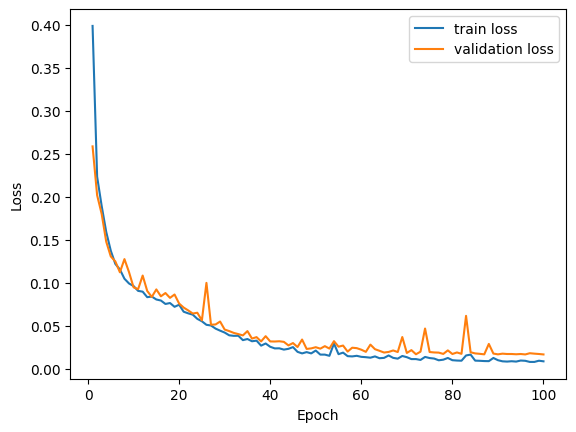

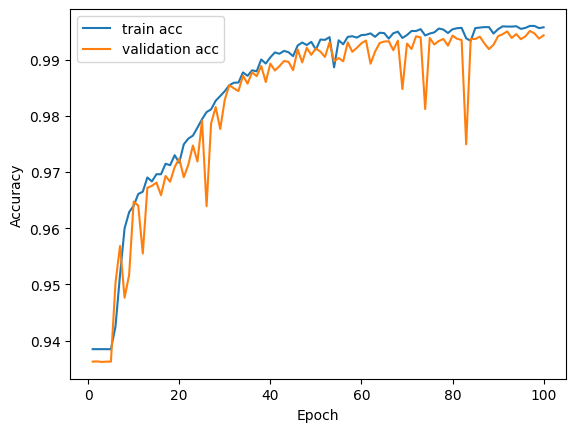

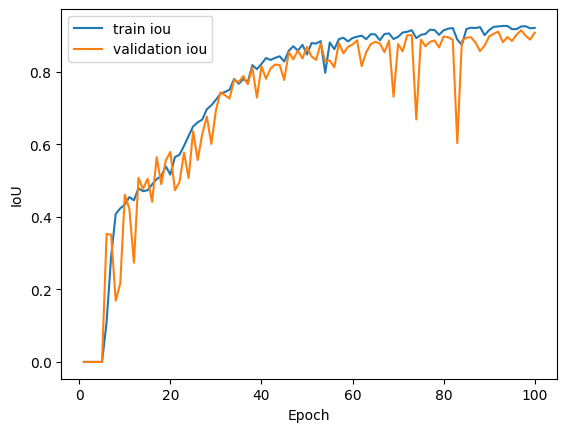

In [26]:
# print('train loss', training_loss)
# print('val loss', validation_loss)
# print('train acc', training_acc)
# print('val acc', validation_acc)
# print('train iou', training_iou)
# print('val iou', validation_iou)
plt.plot(ep, training_loss, label='train loss')
plt.plot(ep, validation_loss, label='validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.plot(ep, training_acc, label='train acc')
plt.plot(ep, validation_acc, label='validation acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.plot(ep, training_iou, label='train iou')
plt.plot(ep, validation_iou, label='validation iou')
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.legend()
plt.show()


# Prediction

In [16]:

def pred_show_image_grid(data_path, model_pth, device):
    model = UNet(in_channels=3, num_classes=1).to(device)
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))
    image_dataset = BarcodeDataset(data_path, test=True)
    images = []
    orig_masks = []
    pred_masks = []

    for img, orig_mask in image_dataset:
        img = img.float().to(device)
        img = img.unsqueeze(0)

        pred_mask = model(img)

        img = img.squeeze(0).cpu().detach()
        img = img.permute(1, 2, 0)

        pred_mask = pred_mask.squeeze(0).cpu().detach()
        pred_mask = pred_mask.permute(1, 2, 0)
        pred_mask[pred_mask < 0] = 0
        pred_mask[pred_mask > 0] = 1

        orig_mask = orig_mask.cpu().detach()
        orig_mask = orig_mask.permute(1, 2, 0)

        images.append(img)
        orig_masks.append(orig_mask)
        pred_masks.append(pred_mask)

    images.extend(orig_masks)
    images.extend(pred_masks)
    fig = plt.figure()
    for i in range(1, 3 * len(image_dataset) + 1):
        fig.add_subplot(3, len(image_dataset), i)
        plt.imshow(images[i - 1], cmap="gray")
        plt.axis("off")
    plt.show()


def single_image_inference(image_pth, save_path, model_pth, device):
    model = UNet(in_channels=3, num_classes=1).to(device)
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))

    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()])

    img = transform(Image.open(image_pth)).float().to(device)
    img = img.unsqueeze(0)

    pred_mask = model(img)

    img = img.squeeze(0).cpu().detach()
    img = img.permute(1, 2, 0)

    pred_mask = pred_mask.squeeze(0).cpu().detach()
    pred_mask = pred_mask.permute(1, 2, 0)
    pred_mask[pred_mask < 0] = 0
    pred_mask[pred_mask > 0] = 1

    # print(type(pred_mask))
    # print(pred_mask.size())
    out_img = pred_mask.squeeze()
    out_img = TF.to_pil_image(out_img)
    # out_path = save_path + '1337.png'
    # print('image saved to out path')
    # out_img.save(out_path)
    # prediction = TF.to_pil_image(pred_mask)
    # Extract the original file name
    file_name = os.path.basename(image_pth)

    # Create the output path by joining the output directory and the modified file name
    output_path = os.path.join(save_path, file_name)

    # Save the processed image
    # prediction.save(output_path)
    fig = plt.figure()
    for i in range(1, 3):
        fig.add_subplot(1, 2, i)
        if i == 1:
            plt.imshow(img, cmap="gray")
            plt.axis("off")
        else:
            plt.imshow(pred_mask, cmap="gray")
            plt.axis("off")
    plt.axis("off")
    plt.show()





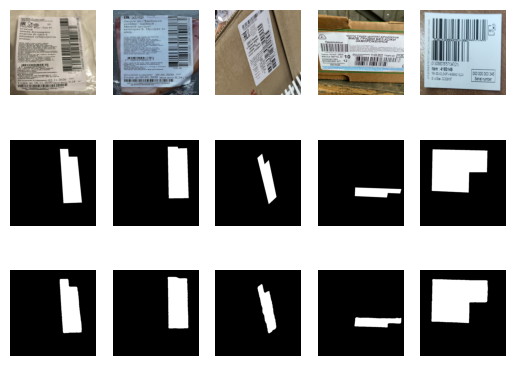

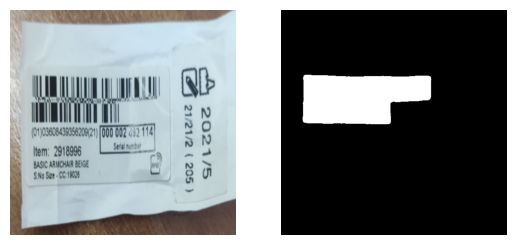

In [21]:

SINGLE_IMG_PATH = "/home/aous/Desktop/MIPT/project/data 3/test/temporary image/1329.png"
SINGLE_IMG_PREDICTED_PATH = "/home/aous/Desktop/MIPT/project/predictions barcode/model_data3_03/"
DATA_PATH = "/home/aous/Desktop/MIPT/project/data 3"
MODEL_PATH = "/home/aous/Desktop/MIPT/project/models/model_data3_03.pth"
    # MODEL_PATH = "/home/aous/Desktop/MIPT/project/U-net from internet/unet.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"
pred_show_image_grid(DATA_PATH, MODEL_PATH, device)
single_image_inference(SINGLE_IMG_PATH,SINGLE_IMG_PREDICTED_PATH, MODEL_PATH, device)



# First row is input, second row is groung truth, third row is prediction

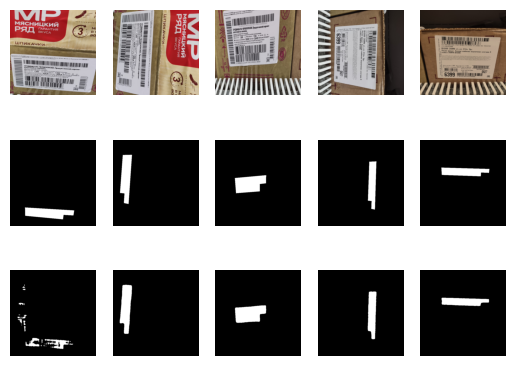

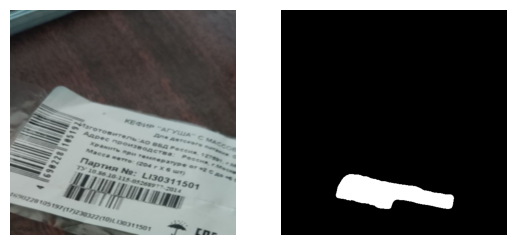

In [22]:

SINGLE_IMG_PATH = "/home/aous/Desktop/MIPT/project/data 3/test/temporary image/1306.png"
SINGLE_IMG_PREDICTED_PATH = "/home/aous/Desktop/MIPT/project/predictions barcode/model_data3_03/"
DATA_PATH = "/home/aous/Desktop/MIPT/project/data 3"
MODEL_PATH = "/home/aous/Desktop/MIPT/project/models/model_data3_03.pth"
    # MODEL_PATH = "/home/aous/Desktop/MIPT/project/U-net from internet/unet.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"
pred_show_image_grid(DATA_PATH, MODEL_PATH, device)
single_image_inference(SINGLE_IMG_PATH,SINGLE_IMG_PREDICTED_PATH, MODEL_PATH, device)



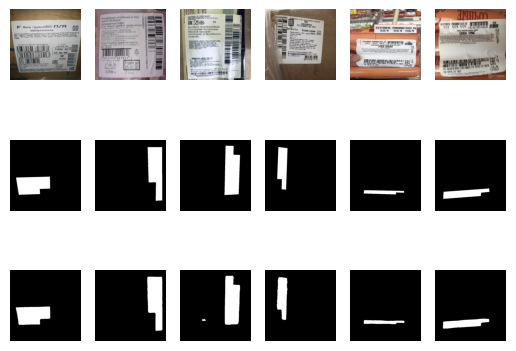

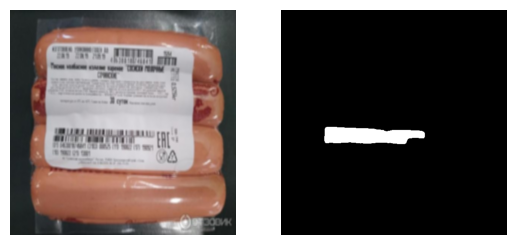

In [24]:
SINGLE_IMG_PATH = "/home/aous/Desktop/MIPT/project/data 3/test/temporary image/1291.png"
SINGLE_IMG_PREDICTED_PATH = "/home/aous/Desktop/MIPT/project/predictions barcode/model_data3_03/"
DATA_PATH = "/home/aous/Desktop/MIPT/project/data 3"
MODEL_PATH = "/home/aous/Desktop/MIPT/project/models/model_data3_03.pth"
    # MODEL_PATH = "/home/aous/Desktop/MIPT/project/U-net from internet/unet.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"
pred_show_image_grid(DATA_PATH, MODEL_PATH, device)
single_image_inference(SINGLE_IMG_PATH,SINGLE_IMG_PREDICTED_PATH, MODEL_PATH, device)

# Making prediction on the model, finding contour features of the predicted model, show the output

In [109]:
def prediction(image_pth, model_pth, device):
    model = UNet(in_channels=3, num_classes=1).to(device)
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))

    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()])

    img = transform(Image.open(image_pth)).float().to(device)
    img = img.unsqueeze(0)

    pred_mask = model(img)

    img = img.squeeze(0).cpu().detach()
    img = img.permute(1, 2, 0)

    pred_mask = pred_mask.squeeze(0).cpu().detach()
    pred_mask = pred_mask.permute(1, 2, 0)
    pred_mask[pred_mask < 0] = 0
    pred_mask[pred_mask > 0] = 1
    # plt.imshow(img,cmap="gray")
    return img, pred_mask




In [110]:
def find_contours(img):
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    vertex_image = img.copy()
    contours_coordinates = []

    for contour in contours:
        epsilon = 0.03 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        for point in approx:
            x, y = point[0]
            contours_coordinates.append([y,x])
            cv2.circle(vertex_image, (x, y), 20, 128, -1)

    # plt.imshow(vertex_image, cmap='gray')

    return contours_coordinates



Example 1:

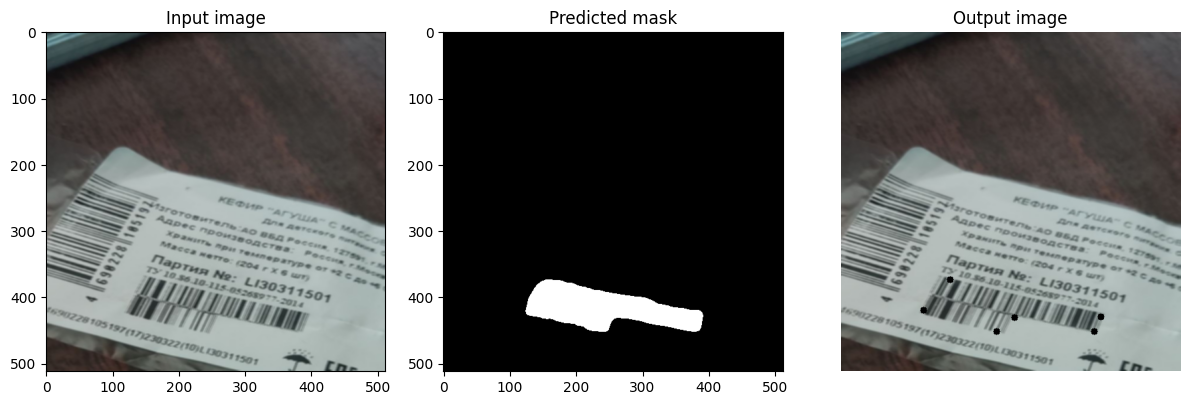

In [112]:
device = "cuda" if torch.cuda.is_available() else "cpu"
input_img_path = "/home/aous/Desktop/MIPT/project/data 3/test/temporary image/1306.png"
input_image = plt.imread(input_img_path)
model_path = "/home/aous/Desktop/MIPT/project/models/model_data3_03.pth"

input_img, predicted_mask = prediction(input_img_path,model_path,device)
predicted_mask = predicted_mask.squeeze()
predicted_mask = predicted_mask.numpy().astype("uint8")
input_img = input_img.squeeze()
input_img = input_img.numpy().astype("uint8")
# plt.imshow(input_img, cmap="gray")

contours_of_pred_mask = find_contours(predicted_mask)
radius = 5
color = 0
expected_out = copy.deepcopy(input_image)


for coor in contours_of_pred_mask:
  cv2.circle(expected_out, (coor[1], coor[0]), radius, color, -1)


fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Adjust the figsize as desired

axes[0].imshow(input_image)
plt.axis("off")
axes[0].set_title('Input image')

axes[1].imshow(predicted_mask,cmap='gray')
plt.axis("off")
axes[1].set_title('Predicted mask')
axes[2].imshow(expected_out)
axes[2].set_title('Output image')
plt.tight_layout()
plt.axis("off")
plt.show()


Example 2 

In [1]:
device = "cuda" if torch.cuda.is_available() else "cpu"
input_img_path = "/home/aous/Desktop/MIPT/project/data 3/test/temporary image/1305.png"
input_image = plt.imread(input_img_path)
model_path = "/home/aous/Desktop/MIPT/project/models/model_data3_03.pth"

input_img, predicted_mask = prediction(input_img_path,model_path,device)
predicted_mask = predicted_mask.squeeze()
predicted_mask = predicted_mask.numpy().astype("uint8")
input_img = input_img.squeeze()
input_img = input_img.numpy().astype("uint8")
# plt.imshow(input_img, cmap="gray")

contours_of_pred_mask = find_contours(predicted_mask)
radius = 5
color = 0
expected_out = copy.deepcopy(input_image)


for coor in contours_of_pred_mask:
  cv2.circle(expected_out, (coor[1], coor[0]), radius, color, -1)


fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Adjust the figsize as desired

axes[0].imshow(input_image)
plt.axis("off")
axes[0].set_title('Input image')

axes[1].imshow(predicted_mask,cmap='gray')
plt.axis("off")
axes[1].set_title('Predicted mask')
axes[2].imshow(expected_out)
axes[2].set_title('Output image')
plt.tight_layout()
plt.axis("off")
plt.show()


NameError: name 'torch' is not defined